In [1]:
import torch
from torchvision import models, datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import types
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cuda


In [ ]:
#resizing the cifar (32x32) to resnet 224x224
transformed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#loading training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformed)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 2)

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformed)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers = 2)

#loading the pretrained model
model_weights = models.ResNet152_Weights.DEFAULT
resnet_model = models.resnet152(weights = model_weights)

#defining number of classes
num_classes = 10

#freezing the existing weights
for param in resnet_model.parameters():
  param.requires_grad = False

#fetching number of input feature from last layer
num_features = resnet_model.fc.in_features

#adding new layer to match CIFAR-10
resnet_model.fc = nn.Linear(num_features, num_classes)

resnet_model = resnet_model.to(device)

#loss, optimiser etc
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

num_epochs = 10

#training model
for epoch in range(num_epochs):

  print(f"Epoch {epoch+1}/{num_epochs} started...")

  resnet_model.train()
  training_loss = 0.0
  training_corrects = 0

  for input, labels in train_loader:
    inputs, labels = input.to(device), labels.to(device)

    optimiser.zero_grad()

    outputs = resnet_model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    loss.backward()
    optimiser.step()

    training_loss += loss.item() * inputs.size(0)
    training_corrects += torch.sum(preds == labels.data)

  train_loss = training_loss / len(train_dataset)
  train_acc = training_corrects.double() / len(train_dataset)

  #validation phase
  resnet_model.eval()
  val_loss = 0.0
  val_corrects = 0

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = resnet_model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      val_loss += loss.item() * inputs.size(0)
      val_corrects += torch.sum(preds == labels.data)

  val_loss = val_loss / len(val_dataset)
  val_acc = val_corrects.double() / len(val_dataset)

  print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
  print(f'Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
  print()

Epoch 1/10 started...
Train Loss: 0.6976 Acc: 0.7857
Val   Loss: 0.5196 Acc: 0.8320

Epoch 2/10 started...
Train Loss: 0.4902 Acc: 0.8366
Val   Loss: 0.4727 Acc: 0.8452

Epoch 3/10 started...
Train Loss: 0.4480 Acc: 0.8491
Val   Loss: 0.4688 Acc: 0.8407

Epoch 4/10 started...
Train Loss: 0.4232 Acc: 0.8564
Val   Loss: 0.4540 Acc: 0.8480

Epoch 5/10 started...
Train Loss: 0.4064 Acc: 0.8615
Val   Loss: 0.4463 Acc: 0.8517

Epoch 6/10 started...
Train Loss: 0.3963 Acc: 0.8657
Val   Loss: 0.4475 Acc: 0.8481

Epoch 7/10 started...
Train Loss: 0.3886 Acc: 0.8668
Val   Loss: 0.4571 Acc: 0.8470

Epoch 8/10 started...
Train Loss: 0.3763 Acc: 0.8724
Val   Loss: 0.4449 Acc: 0.8536

Epoch 9/10 started...
Train Loss: 0.3723 Acc: 0.8721
Val   Loss: 0.4625 Acc: 0.8464

Epoch 10/10 started...
Train Loss: 0.3638 Acc: 0.8750
Val   Loss: 0.4530 Acc: 0.8521



Disable skip connections in a few selected residual blocks and re-train the modified network head.


Baseline (with skip)

Training Baseline
Epoch 1/10 - Train Acc: 0.7857, Val Acc: 0.8367
Epoch 2/10 - Train Acc: 0.8379, Val Acc: 0.8429
Epoch 3/10 - Train Acc: 0.8492, Val Acc: 0.8470
Epoch 4/10 - Train Acc: 0.8567, Val Acc: 0.8533
Epoch 5/10 - Train Acc: 0.8622, Val Acc: 0.8448
Epoch 6/10 - Train Acc: 0.8640, Val Acc: 0.8473
Epoch 7/10 - Train Acc: 0.8694, Val Acc: 0.8463
Epoch 8/10 - Train Acc: 0.8716, Val Acc: 0.8470
Epoch 9/10 - Train Acc: 0.8731, Val Acc: 0.8503
Epoch 10/10 - Train Acc: 0.8753, Val Acc: 0.8440

Modified (no skip)
Disabled skip in layer3[5]
Disabled skip in layer4[0]

Training Modified
Epoch 1/10 - Train Acc: 0.1506, Val Acc: 0.1759
Epoch 2/10 - Train Acc: 0.1714, Val Acc: 0.1835
Epoch 3/10 - Train Acc: 0.1778, Val Acc: 0.1814
Epoch 4/10 - Train Acc: 0.1842, Val Acc: 0.1888
Epoch 5/10 - Train Acc: 0.1870, Val Acc: 0.1898
Epoch 6/10 - Train Acc: 0.1909, Val Acc: 0.1874
Epoch 7/10 - Train Acc: 0.1876, Val Acc: 0.1886
Epoch 8/10 - Train Acc: 0.1885, Val Acc: 0.1909
E

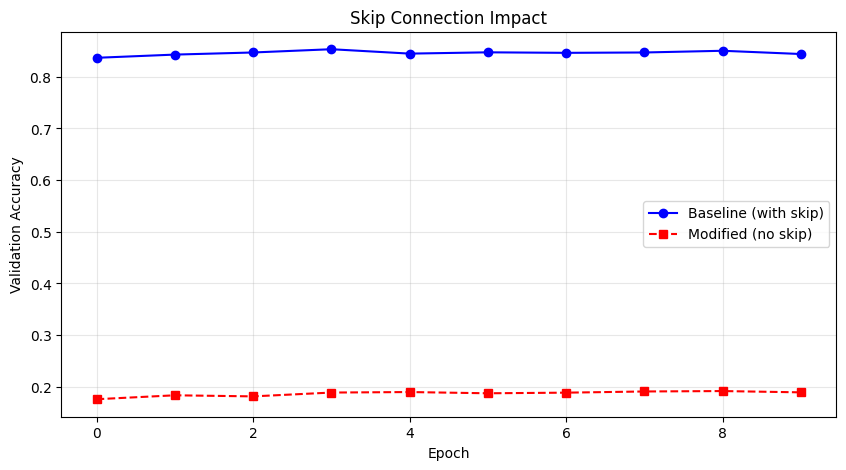

In [6]:
#resizing the cifar (32x32) to resnet 224x224
transformed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#loading training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformed)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 2)

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformed)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers = 2)

#defining number of classes
num_classes = 10

#forward pass without skip connection
def no_skip_forward(self, x):
  out = self.conv1(x)
  out = self.bn1(out)
  out = self.relu(out)

  out = self.conv2(out)
  out = self.bn2(out)
  out = self.relu(out)

  out = self.conv3(out)
  out = self.bn3(out)

  if self.downsample is not None:
    identity = self.downsample(x)
    if out.size(1) != identity.size(1):
      out = torch.nn.functional.pad(out, [0, 0, 0, 0, 0, identity.size(1) - out.size(1)])

  out = self.relu(out)
  return out

#function to disable skip connections
def disable_skip_in_block(resnet_model, layer_name, block_index):
  layer = getattr(resnet_model, layer_name)
  block = layer[block_index]
  block.forward = types.MethodType(no_skip_forward, block)
  print(f"Disabled skip in {layer_name}[{block_index}]")

#training function
def train_model(resnet_model, model_name, num_epochs=10):

  #freezing all parameters except final layer
  for param in resnet_model.parameters():
    param.requires_grad = False

  #replacing final layer
  num_features = resnet_model.fc.in_features
  resnet_model.fc = nn.Linear(num_features, num_classes)
  resnet_model = resnet_model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimiser = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

  history = {'train_acc': [], 'val_acc': []}

  print(f"\nTraining {model_name}")

  for epoch in range(num_epochs):

    #training phase
    resnet_model.train()
    training_loss = 0.0
    training_corrects = 0

    for input, labels in train_loader:
      inputs, labels = input.to(device), labels.to(device)

      optimiser.zero_grad()
      outputs = resnet_model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimiser.step()

      training_loss += loss.item() * inputs.size(0)
      training_corrects += (outputs.argmax(1) == labels).sum().item()

    train_acc = training_corrects / len(train_dataset)

    #validation phase
    resnet_model.eval()
    val_corrects = 0

    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        val_corrects += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_corrects / len(val_dataset)

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

  return history

#baseline model
print("\nBaseline (with skip)")
baseline_model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
baseline_history = train_model(baseline_model, "Baseline", num_epochs=10)

#modified model
print("\nModified (no skip)")
modified_model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
disable_skip_in_block(modified_model, 'layer3', 5)
disable_skip_in_block(modified_model, 'layer4', 0)
modified_history = train_model(modified_model, "Modified", num_epochs=10)

#results
print(f"\nBaseline Val Acc: {baseline_history['val_acc'][-1]:.4f}")
print(f"Modified Val Acc: {modified_history['val_acc'][-1]:.4f}")
print(f"Accuracy Drop: {(baseline_history['val_acc'][-1] - modified_history['val_acc'][-1])*100:.2f}%")

#plotting
plt.figure(figsize=(10, 5))
plt.plot(baseline_history['val_acc'], 'b-', marker='o', label='Baseline (with skip)')
plt.plot(modified_history['val_acc'], 'r--', marker='s', label='Modified (no skip)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Skip Connection Impact')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('skip_comparison.png')
plt.show()

Collecting features from Early, Middle and Late layer

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 201MB/s]
100%|██████████| 170M/170M [00:19<00:00, 8.70MB/s]


Extracting features...
Running t-SNE...


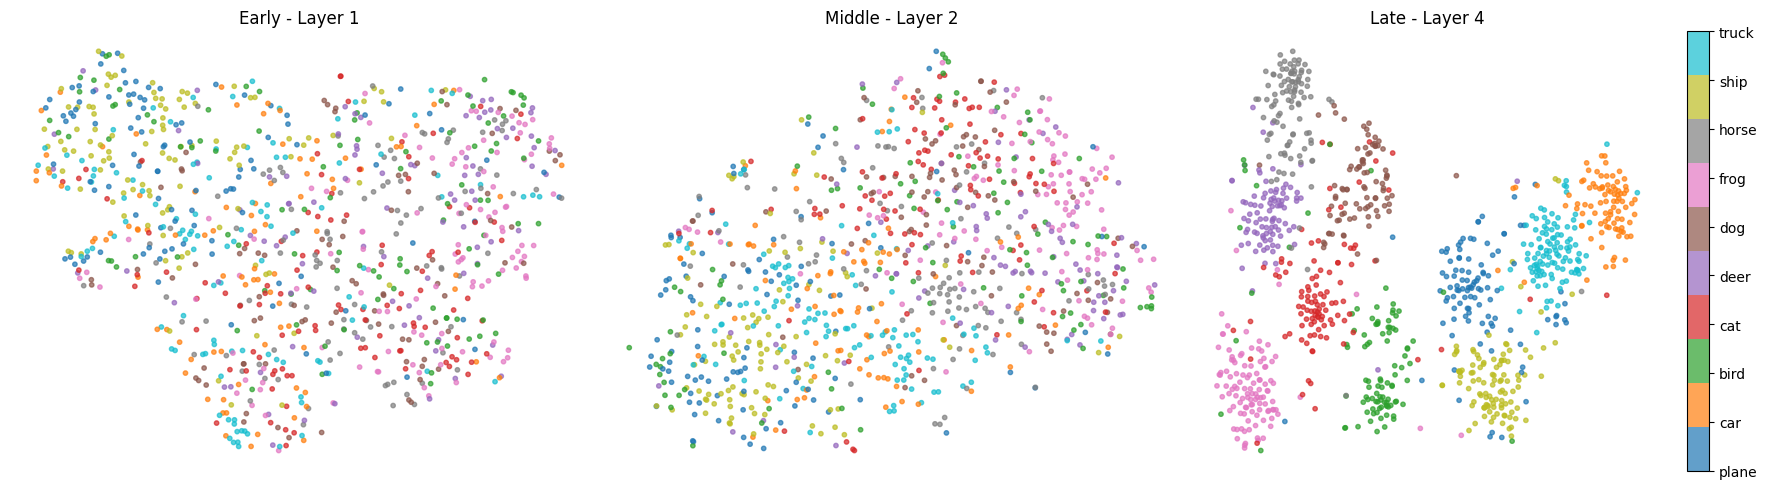

Plot saved as 'feature_hierarchy.png'


In [4]:
#loading pretrained model
model_weights = models.ResNet152_Weights.DEFAULT
resnet_model = models.resnet152(weights=model_weights)
resnet_model = resnet_model.to(device)
resnet_model.eval()

#storing features from different layers
features = {'early': [], 'middle': [], 'late': []}

#hook function to collect features
def get_features(name):
  def hook(model, input, output):
    pooled_output = torch.mean(output, dim=[2, 3])
    features[name].append(pooled_output.detach().cpu().numpy())
  return hook

#registering hooks on different layers
resnet_model.layer1.register_forward_hook(get_features('early'))
resnet_model.layer2.register_forward_hook(get_features('middle'))
resnet_model.layer4.register_forward_hook(get_features('late'))

#transforming data
transformed = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#loading test dataset with subset for speed
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformed)
test_subset = torch.utils.data.Subset(test_dataset, list(range(1000)))
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

#extracting features
labels_list = []

print("Extracting features...")
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    _ = resnet_model(inputs)
    labels_list.extend(labels.numpy())

#combining batches
for key in features:
  features[key] = np.concatenate(features[key], axis=0)

labels_list = np.array(labels_list)

#running t-sne and plotting
print("Running t-SNE...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
layer_names = ['early', 'middle', 'late']
layer_numbers = [1, 2, 4]
cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, layer in enumerate(layer_names):

  tsne = TSNE(n_components=2, random_state=42, perplexity=30)
  features_embedded = tsne.fit_transform(features[layer])

  scatter = axes[i].scatter(features_embedded[:, 0], features_embedded[:, 1],
                           c=labels_list, cmap='tab10', s=10, alpha=0.7)
  axes[i].set_title(f'{layer.capitalize()} - Layer {layer_numbers[i]}')
  axes[i].axis('off')

#adding legend
cbar = plt.colorbar(scatter, ax=axes[2])
cbar.set_ticks(range(10))
cbar.set_ticklabels(cifar_classes)

plt.tight_layout()
plt.savefig('feature_hierarchy.png')
plt.show()

print("Plot saved as 'feature_hierarchy.png'")

Transfer learning



Random Initialization
Epoch 1/6 - Val Acc: 0.0860
Epoch 2/6 - Val Acc: 0.1480
Epoch 3/6 - Val Acc: 0.1660
Epoch 4/6 - Val Acc: 0.2020
Epoch 5/6 - Val Acc: 0.1480
Epoch 6/6 - Val Acc: 0.2180

Pretrained Full Fine-tuning
Epoch 1/6 - Val Acc: 0.8000
Epoch 2/6 - Val Acc: 0.8800
Epoch 3/6 - Val Acc: 0.9020
Epoch 4/6 - Val Acc: 0.9120
Epoch 5/6 - Val Acc: 0.8860
Epoch 6/6 - Val Acc: 0.8860

Pretrained Final Block Only
Epoch 1/6 - Val Acc: 0.7040
Epoch 2/6 - Val Acc: 0.7860
Epoch 3/6 - Val Acc: 0.8020
Epoch 4/6 - Val Acc: 0.8140
Epoch 5/6 - Val Acc: 0.8120
Epoch 6/6 - Val Acc: 0.8240

Final Results:
Random Init: 0.2180
Pretrained Full: 0.8860
Pretrained Block: 0.8240


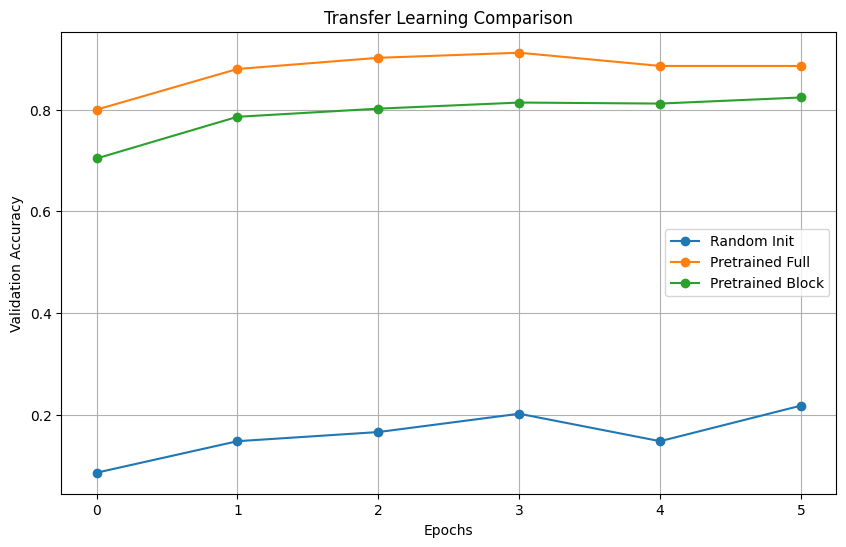

In [5]:
#resizing the cifar (32x32) to resnet 224x224
transformed = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#loading training dataset with subset for speed
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformed)
train_subset = torch.utils.data.Subset(train_dataset, list(range(2000)))
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

#loading validation dataset with subset
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformed)
val_subset = torch.utils.data.Subset(val_dataset, list(range(500)))
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

#defining number of classes
num_classes = 10

#function to setup model
def setup_model(experiment_type):

  if experiment_type == 'random':
    resnet_model = models.resnet152(weights=None)
    for param in resnet_model.parameters():
      param.requires_grad = True

  elif experiment_type == 'pretrained_full':
    model_weights = models.ResNet152_Weights.DEFAULT
    resnet_model = models.resnet152(weights=model_weights)
    for param in resnet_model.parameters():
      param.requires_grad = True

  elif experiment_type == 'pretrained_block':
    model_weights = models.ResNet152_Weights.DEFAULT
    resnet_model = models.resnet152(weights=model_weights)

    for param in resnet_model.parameters():
      param.requires_grad = False
    for param in resnet_model.layer4.parameters():
      param.requires_grad = True
    for param in resnet_model.fc.parameters():
      param.requires_grad = True

  #replacing final layer
  num_features = resnet_model.fc.in_features
  resnet_model.fc = nn.Linear(num_features, num_classes)

  return resnet_model.to(device)

#training function
def train_model(resnet_model, num_epochs=6):

  criterion = nn.CrossEntropyLoss()
  optimiser = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-4)

  accuracies = []

  for epoch in range(num_epochs):

    #training phase
    resnet_model.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimiser.zero_grad()
      loss = criterion(resnet_model(inputs), labels)
      loss.backward()
      optimiser.step()

    #validation phase
    resnet_model.eval()
    val_corrects = 0

    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        val_corrects += (preds == labels).sum().item()

    val_acc = val_corrects / len(val_subset)
    accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Val Acc: {val_acc:.4f}")

  return accuracies

#storing results
results = {}

#experiment 1: random initialization
print("\nRandom Initialization")
resnet_random = setup_model('random')
results['Random Init'] = train_model(resnet_random, num_epochs=6)

#experiment 2: pretrained full fine-tuning
print("\nPretrained Full Fine-tuning")
resnet_full = setup_model('pretrained_full')
results['Pretrained Full'] = train_model(resnet_full, num_epochs=6)

#experiment 3: pretrained final block only
print("\nPretrained Final Block Only")
resnet_block = setup_model('pretrained_block')
results['Pretrained Block'] = train_model(resnet_block, num_epochs=6)

#printing final results
print("\nFinal Results:")
for name, accs in results.items():
  print(f"{name}: {accs[-1]:.4f}")

#plotting comparison
plt.figure(figsize=(10, 6))
for name, accs in results.items():
  plt.plot(accs, marker='o', label=name)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Transfer Learning Comparison')
plt.legend()
plt.grid(True)
plt.savefig('transfer_learning_comparison.png')
plt.show()